# Log File Outlier Detection

**Company Use Case:**

Due to the potential presence of sensitive patient data, log files cannot be shared or processed on the cloud directly. Homomorphic encryption comes into play by encrypting the log files and enabling predictive filtering of sensitive lines within them. This approach ensures data privacy while allowing for the extraction of valuable insights, particularly beneficial for enhancing predictive maintenance efforts.

**Approach:**

Since it's unknown which sensitive information could be contained in the log files the goal is to implement an anomaly detection algorithm which is trained on "normal samples" (in this use case _warnings_ and _notices_).

The following Notebook will show two approaches to do this with ConcreteML.

**Dataset Information:**

Apache HTTP Server is one of the most popular web servers. Apache servers usually generate two types of logs: access logs and error logs. We provide an error log for the purpose of research on anomaly detection and diagnosis. The log file was collected from a Linux system running Apache Web server.

**Dataset Source:**

https://github.com/logpai/loghub/tree/master

https://zenodo.org/records/8196385/files/Apache.tar.gz?download=1

# Imports

In [1]:
# Basic Imports
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from tqdm import tqdm

# Scipy
from scipy import stats

# Wordcloud
from wordcloud import WordCloud


# Preprocessing
from unidecode import unidecode
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('snowball_data')
nltk.download('averaged_perceptron_tagger')

# Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest

# XGBoost
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor

# Torch
import torch

# Transformers
from transformers import BertTokenizer, BertModel

# Concrete ML
from concrete.ml.sklearn import LogisticRegression as ConcreteLogisticRegression
from concrete.ml.sklearn import XGBClassifier as ConcreteXGBClassifier
from concrete.ml.sklearn import XGBRegressor as ConcreteXGBRegressor
from concrete.ml.torch.compile import compile_brevitas_qat_model

# Brevitas
import brevitas

# Smote
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data] Downloading package snowball_data to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# General Functions

In [4]:
################################################################################
# Extract Log Information to Dataframe (Apache)
################################################################################

def extract_log_information_apache(
    log_file_path
    ):

  '''
  Reads Apache log files to Pandas dataframe

  Input:
    log_file_path = path to the log file

  Output:
    log_df        = dataframe
  '''

  # Define the pattern to extract information
  pattern = re.compile(r'\[(.*?)\] \[(.*?)\] (.*)')

  # Initialize lists to store extracted information
  log_dict = {'timestamp': [], 'log_level': [], 'log_message': []}

  # Read through the log file and extract information
  with open(log_file_path, 'r') as log_file:
    for line in log_file:
      match = pattern.match(line)
      if match:
        log_dict['timestamp'].append(match.group(1))
        log_dict['log_level'].append(match.group(2))
        log_dict['log_message'].append(match.group(3))

  # Create a DataFrame
  log_df = pd.DataFrame(log_dict)

  # Convert Timestamp to datetime format
  log_df['timestamp'] = pd.to_datetime(log_df['timestamp'], format='%a %b %d %H:%M:%S %Y')

  # Save as .csv
  new_dest = os.path.abspath(os.getcwd()) + '/ApacheLog.csv'
  log_df.to_csv(new_dest, index=False)
  print(f'File saved to: {new_dest}')

  # return dataframe
  return log_df

################################################################################
# Extract Log Information to Dataframe (Hadoop)
################################################################################

# def extract_log_information_hadoop(log_file_path):
#   data = {'log': []}

#   # iterate through subdirectories and read log files
#   for root, dirs, files in os.walk(log_file_path):
#     for file in files:
#       if file.endswith('.log'):
#         folder_name = os.path.basename(root)
#         file_path = os.path.join(root, file)
#         with open(file_path, 'r') as log_file:
#           lines = log_file.readlines()
#           for line in lines:
#             data['log'].append(line.strip())

#   # creating the DataFrame
#   log_df = pd.DataFrame(data)
#   # create labels
#   log_df = log_df[log_df['log'].apply(lambda x: len(x.split(' ')) > 2 and x.split(' ')[2] in ['WARN', 'ERROR', 'INFO'])]
#   log_df['label'] = log_df['log'].apply(lambda x: x.split(' ')[2])
#   log_df['log'] = log_df['log'].apply(lambda x: ' '.join(x.split(' ')[3:]))

#   # Save as .csv
#   new_dest = os.path.abspath(os.getcwd()) + '/HadoopLog.csv'
#   log_df.to_csv(new_dest, index=False)
#   print(f'File saved to: {new_dest}')

#   # return dataframe
#   return log_df

################################################################################
# Wordcount
################################################################################

def wordcount(
    dataframe,
    text_column,
    class_column,
    n: int = 20
    ):

  '''
  Plot Barchart of the n most frequent tokens

  Input:
    dataframe     = data
    text_column   = select specific text column
    class_column  = to plot most frequent tokens per class
    n             = number of most frequent words
  '''

  unique_classes = dataframe[class_column].unique()

  fig, axs = plt.subplots(len(unique_classes), 1, figsize=(10, 7 * len(unique_classes)))

  for i, class_label in enumerate(unique_classes):
    class_data = dataframe[dataframe[class_column] == class_label]

    # Calculate the most frequent words in the specified column for the current class
    words_count = class_data[text_column].str.split(expand=True).stack().value_counts().head(n)

    # Sort the words based on their frequency in descending order
    words_count = words_count.sort_values(ascending=True)

    # Plot the most frequent words as a bar chart
    axs[i].barh(words_count.index, words_count.values)
    axs[i].set_title(f'Most Frequent Words in {text_column.title()} (Class: {class_label})')
    axs[i].set_xlabel('Count')
    axs[i].set_ylabel('Word')

  plt.show()

################################################################################
# Plot Classification Metrics
################################################################################

def plot_classification_metrics(
    y_true: np.array,
    y_pred: np.array,
    plot_title: str = None
    ):

    '''
    Plots Classification Metrics

    Input:
      y_true = ground truth labels
      y_pred = prediction labels
      plot_title = title for results plot (optional)
    '''

    fig, ax = plt.subplots(2, 1, figsize=(5, 5))
    ax = ax.flatten()

    accuracy = round(accuracy_score(y_true, y_pred),2)
    precision = round(precision_score(y_true, y_pred),2)
    recall = round(recall_score(y_true, y_pred),2)
    f1 = round(f1_score(y_true, y_pred),2)
    roc_auc = round(roc_auc_score(y_true, y_pred), 2)

    # barchart of metrics for each classifier
    ax[0].bar(['Accuracy', 'Precision', 'Recall', 'F1', 'RocAuc'], [accuracy, precision, recall, f1, roc_auc])
    ax[0].set_title('Classifier Metrics')
    ax[0].set_ylim(0,1)
    ax[0].bar_label(ax[0].containers[0], label_type='center')

    # confusion matrix for each classifier
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot(ax=ax[1], cmap='Blues', colorbar=False)
    ax[1].set_title('Classifier Confusion Matrix')

    plt.suptitle(plot_title)
    plt.tight_layout()

    plt.show()

# Load Data

In [5]:
df_apache = extract_log_information_apache('ApacheLog.log')
# df_hadoop = extract_log_information_hadoop('HadoopLog')

File saved to: /content/drive/MyDrive/Thesis/UCLogFiles/ApacheLog.csv


# Exploratory Data Analysis

In [6]:
dataframe = df_apache.copy()
target_feature = 'log_level'

In [7]:
# Display head & tail
dataframe

,timestamp,log_level,log_message
0,2005-06-09 06:07:04,notice,LDAP: Built with OpenLDAP LDAP SDK
1,2005-06-09 06:07:04,notice,LDAP: SSL support unavailable
2,2005-06-09 06:07:04,notice,suEXEC mechanism enabled (wrapper: /usr/sbin/s...
3,2005-06-09 06:07:05,notice,Digest: generating secret for digest authentic...
4,2005-06-09 06:07:05,notice,Digest: done
...,...,...,...
51999,2006-02-27 21:56:11,error,[client 220.225.166.39] Directory index forbid...
52000,2006-02-28 00:45:58,error,[client 206.125.60.10] Directory index forbidd...
52001,2006-02-28 00:46:47,error,[client 203.186.238.253] Directory index forbi...
52002,2006-02-28 03:04:53,error,[client 69.39.5.163] Directory index forbidden...


In [8]:
# Data types
print('Data Types:\n')
dataframe.dtypes

Data Types:



timestamp      datetime64[ns]
log_level              object
log_message            object
dtype: object

In [9]:
# Missing values
print('Missing Values:', '\n')
pd.concat([dataframe.isnull().sum(), dataframe.eq('').sum()], keys=['Nulls','Empty Strings'], axis=1)

Missing Values: 



,Nulls,Empty Strings
timestamp,0,0
log_level,0,0
log_message,0,0


In [10]:
# duplicated rows
print('Duplicated Rows:\n')
dataframe.duplicated().sum()

Duplicated Rows:



23679

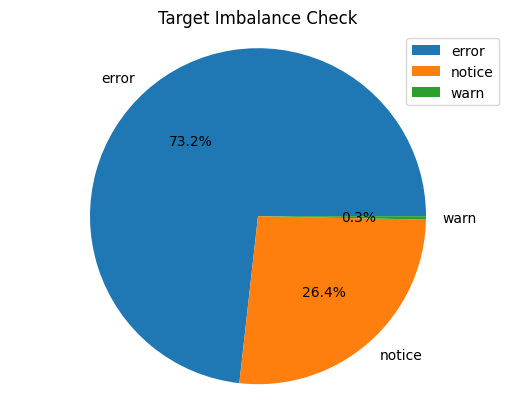

In [11]:
# check for imbalance
# Count the number of instances for each target value
target_counts = dataframe[target_feature].value_counts()

# Create a pie chart
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Target Imbalance Check')
plt.legend()
plt.show()

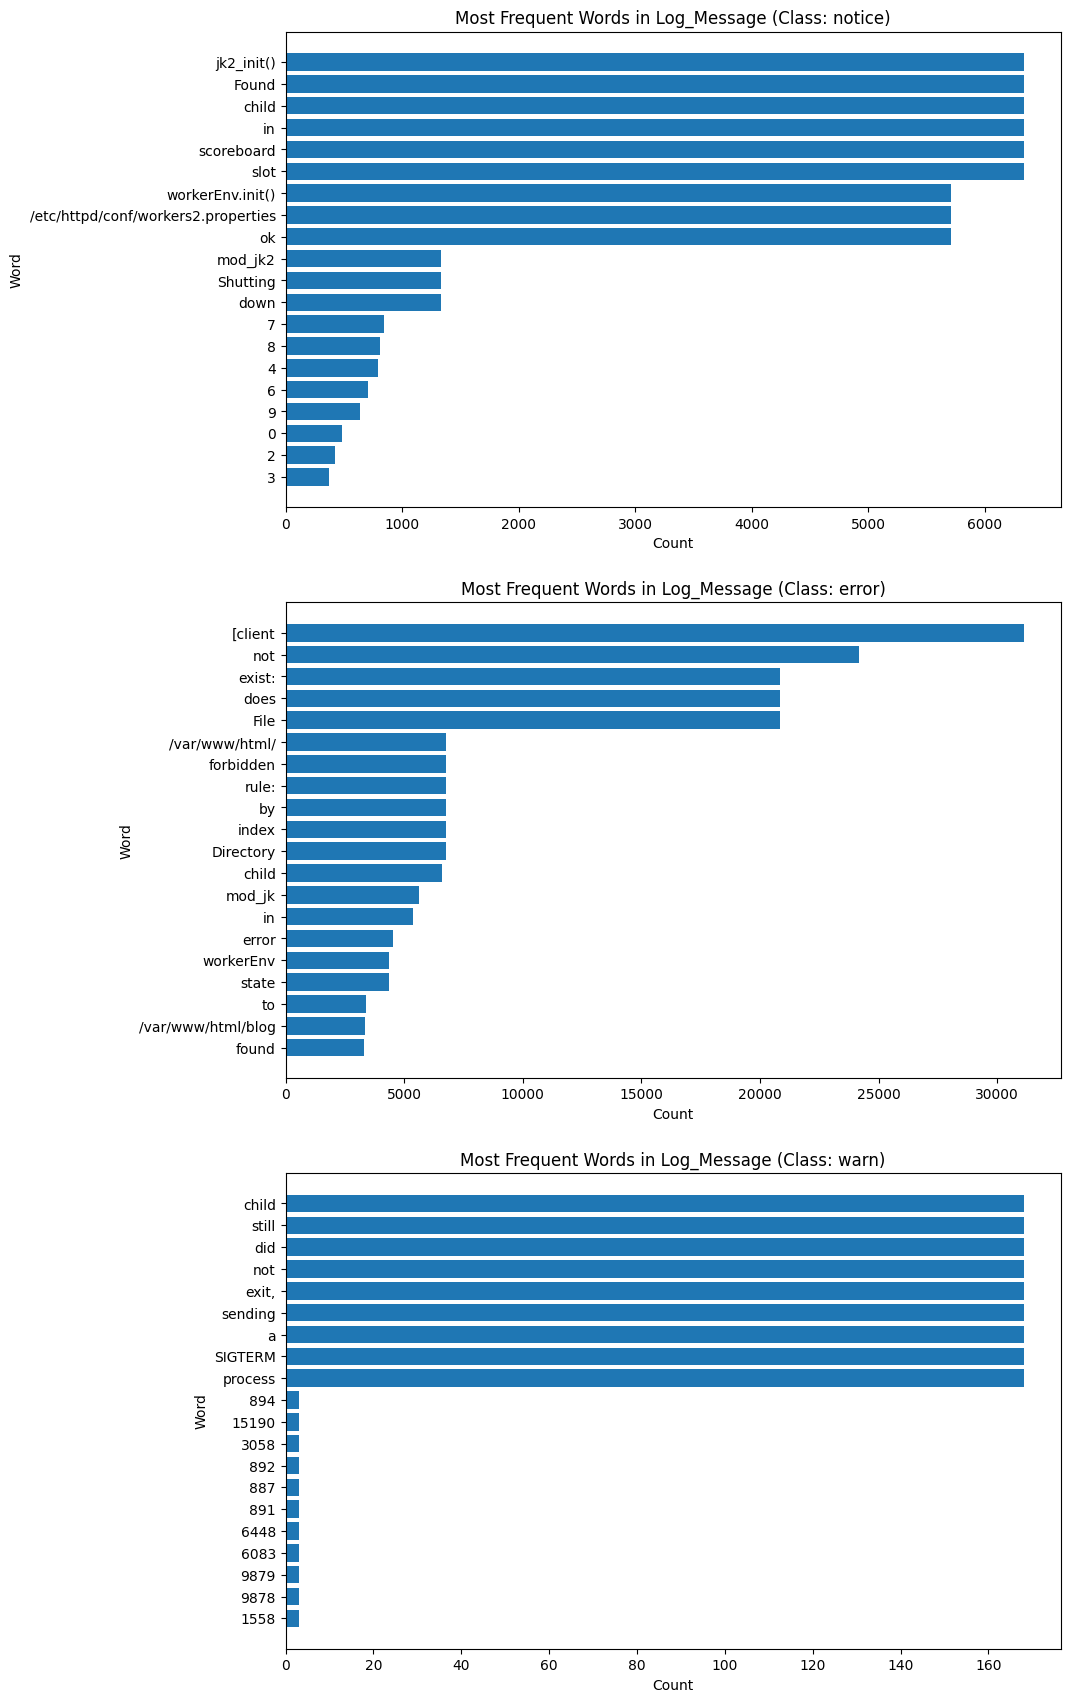

In [12]:
# Plot most frequent words per class
wordcount(dataframe, 'log_message', 'log_level', n=20)

# Preprocessing

## Functions

In [13]:
################################################################################
# Preprocessing
################################################################################

def text_preprocessing(
    dataframe
    ):

  '''
  Text Preprocessing Pipeline

  Input:
    dataframe

  Output:
    transformed dataframe
  '''

  categorical_features = list(dataframe.select_dtypes(exclude = np.number).columns)
  stop_words = set(stopwords.words('english'))
  lemmatizer = nltk.stem.WordNetLemmatizer()

  regex_patterns = {
    # basic patterns
    # remove url
    r'http\S+':                     ' ',
    # remove html tags
    r'<.*?>':                       ' ',
    # remove punctuation
    r'[^\w\s]':                     ' ',
    # remove numbers
    r'\d+':                         ' ',
    # remove multiple whitespace
    r'\s+':                         ' ',
    # remove newline
    r'\n':                          ' '
  }

  # lowercase non-numeric features and convert to ASCII using unidecode
  for col in categorical_features:
    dataframe[col] = dataframe[col].apply(lambda x: unidecode(x.lower()) if type(x) == str else '')

  # # drop duplicates
  dataframe = dataframe.drop_duplicates()

  # fill empty cells
  for col in categorical_features:
    dataframe[col] = dataframe[col].fillna('')

  # re.sub regex patterns (dictionary defined in the cell above)
  for col in categorical_features:
    for key, value in regex_patterns.items():
      dataframe[col] = dataframe[col].apply(lambda x: re.sub(key,value,x))

  # tokenize and remove stopwords
  for col in categorical_features:
    dataframe[col] = dataframe[col].apply(lambda x: [word for word in word_tokenize(x) if word not in stop_words])

  # part-of-speech tagging
  for col in categorical_features:
    dataframe[col] = dataframe.apply(lambda row: nltk.pos_tag(row[col]), axis=1)
    # wordnet mapping
    pos_tag_map = {
    'J': wordnet.ADJ,
    'V': wordnet.VERB,
    'N': wordnet.NOUN,
    'R': wordnet.ADV
    }

    dataframe[col] = dataframe.apply(lambda row: [(word, pos_tag_map.get(tag[0])) for word, tag in row[col]], axis=1)

  # lemmatizing
  for col in categorical_features:
    dataframe[col] = dataframe.apply(lambda row: [lemmatizer.lemmatize(word, tag) if tag else word for word, tag in row[col]], axis=1)

  # combine again
  for col in categorical_features:
    dataframe[col] = dataframe[col].apply(lambda x: ' '.join(x))

  # fill empty cells after stopword removal
  for col in categorical_features:
    dataframe[col] = dataframe[col].fillna('')

  return dataframe

################################################################################
# Generate Bert-Embeddings
################################################################################

def bert_embeddings(data):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained("bert-base-uncased")
    # tokenize the text in the Series and get the attention masks
    tokenized = tokenizer(data.tolist(), padding=True, truncation=True, return_tensors='pt')
    # extract pooled outputs
    with torch.no_grad():
      outputs = model(**tokenized).pooler_output.numpy()
    # return 2D numpy array
    return outputs

## Cleaning

In [14]:
dataframe_preprocessed = text_preprocessing(dataframe)

In [15]:
print(f'Text before cleaning:\n{dataframe.iloc[0,2]}')
print(f'Text after cleaning:\n{dataframe_preprocessed.iloc[0,2]}')

Text before cleaning:
ldap: built with openldap ldap sdk
Text after cleaning:
ldap build openldap ldap sdk


## Train/Test Split

In [16]:
x, y = dataframe_preprocessed['log_message'], dataframe_preprocessed['log_level']

le = LabelEncoder()
y = le.fit_transform(y)

# xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=1500, stratify=y, random_state=1)

################################################################################
# modify data for anomaly detection
################################################################################

# Step 1: limiting the training data to only two classes
# 1 = notice, 2 = warn
indices = np.where(np.isin(ytrain, [1, 2]))
xtrain, ytrain = xtrain.iloc[indices], ytrain[indices]
# Step 2: modify the labels in the test data
# assign samples from class 0 to label 1 (outlier=True)
# assign samples from class 1 & 2 to label 0 (outlier=False)
ytest = np.array([0 if i in [1,2] else 1 for i in ytest])

In [17]:
print(f'Observations xtrain: {xtrain.shape[0]}')
print(f'Observations xtest: {xtest.shape[0]}')

Observations xtrain: 5683
Observations xtest: 1500


In [18]:
print(f'Classes in train dataset:\n{le.inverse_transform(np.unique(ytrain))}')
print(f'Classes in test dataset (0 = innlier, 1 = outlier):\n{np.unique(ytest)}')

Classes in train dataset:
['notice' 'warn']
Classes in test dataset (0 = innlier, 1 = outlier):
[0 1]


## Embeddings (BERT)

In [19]:
xtrain_bert = bert_embeddings(xtrain)
xtest_bert = bert_embeddings(xtest)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# Modelling

## Approach 1: IsolationForest & XGBoost

ConcreteML lacks support for "One Class Classification". To address this limitation, a potential workaround involves initially training an IsolationForest from the Scikit-learn library to generate anomaly labels. These labels can then serve as the classifier target for training an XGBClassifier, which can operate in conjunction with ConcreteML, allowing for the utilization of homomorphic encryption while accommodating the absence of direct support for One Class Classification within ConcreteML.
<br></br>

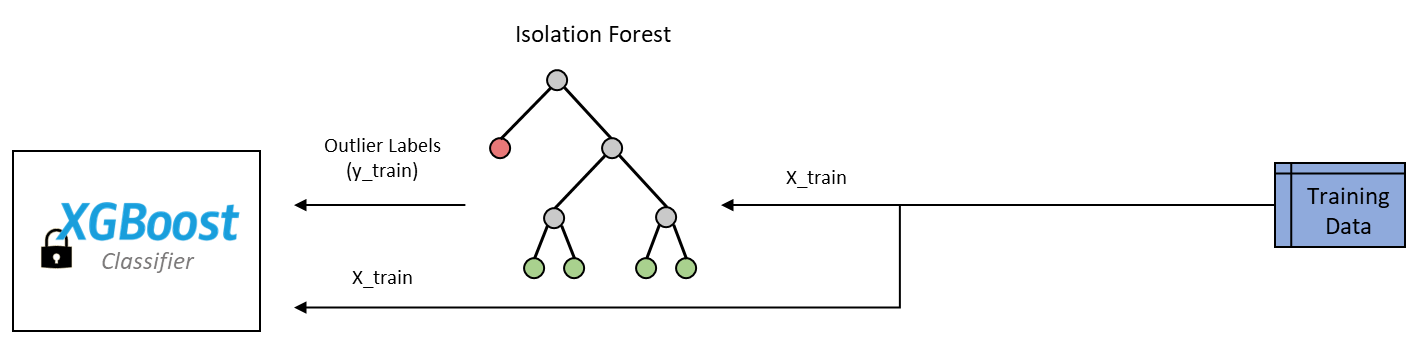

### Functions

In [20]:
################################################################################
# XGBoost Anomaly Detector
################################################################################

class AnomalyDetector:
  def __init__(self, random_state=None):
    self.random_state = random_state
    self.xgb = None
    self.iso = None
    self.log = {
        'train':       None,
        'evaluate_total':  None,
        'evaluate_sample': None
      }

  def train(self, X):
    # training
    start_time = time.time()
    self.iso = IsolationForest(random_state=self.random_state).fit(X)
    ytrain_iso = np.where(self.iso.predict(X) == -1, 1, 0)
    self.xgb = XGBClassifier(random_state=self.random_state).fit(X, ytrain_iso)
    self.log['train'] = time.time() - start_time
    return self

  def evaluate(self, X, model='xgb'):
    if model=='xgb':
      # predict
      start_time = time.time()
      ypred = self.xgb.predict(X)
      self.log['evaluate_total'] = time.time() - start_time
      self.log['evaluate_sample'] = self.log['evaluate_total']/len(X)
      return ypred
    elif model=='iso':
      return np.where(self.iso.predict(X) == -1, 1, 0)

################################################################################
# Concrete Anomaly Detector
################################################################################

class ConcreteAnomalyDetector:
  def __init__(self, n_bits=2, random_state=None):
    self.n_bits = n_bits
    self.random_state = random_state
    self.xgb = None
    self.iso = None
    self.fhe_circuit = None
    self.log = {
        'train':       None,
        'compile':        None,
        'keygen':         None,
        'evaluate_total':  None,
        'evaluate_sample': None
      }

  def train(self, X):
    # training
    start_time = time.time()
    self.iso = IsolationForest(random_state=self.random_state).fit(X)
    ytrain_iso = np.where(self.iso.predict(X) == -1, 1, 0)
    self.xgb = ConcreteXGBClassifier(n_bits=self.n_bits, random_state=self.random_state).fit(X, ytrain_iso)
    self.log['train'] = time.time() - start_time
    # compile
    start_time = time.time()
    self.fhe_circuit = self.xgb.compile(X[:100])
    self.log['compile'] = time.time() - start_time
    return self

  def evaluate(self, X, fhe='simulate'):
    # key generation
    start_time = time.time()
    self.fhe_circuit.keygen(force=True)
    self.log['keygen'] = time.time() - start_time
    # predict
    start_time = time.time()
    ypred = [self.xgb.predict(X[[i], :], fhe=fhe)[0] for i in tqdm(range(X.shape[0]))]
    self.log['evaluate_total'] = time.time() - start_time
    self.log['evaluate_sample'] = self.log['evaluate_total']/len(X)
    return ypred

### XGBoost

In [21]:
ad = AnomalyDetector(random_state=1).train(xtrain_bert)

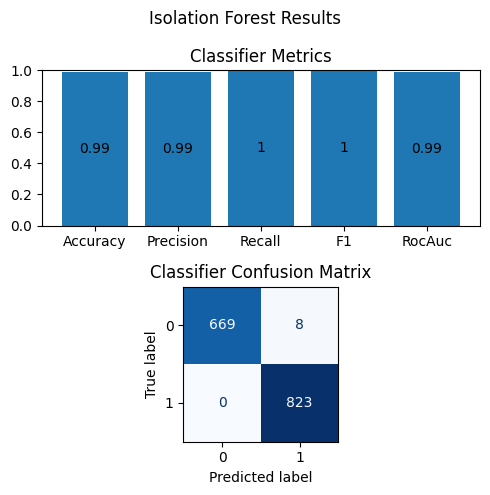

In [22]:
# predict and plot Isolation Forest results
ypred_iso = ad.evaluate(xtest_bert, model='iso')
plot_classification_metrics(ytest, ypred_iso, plot_title='Isolation Forest Results')

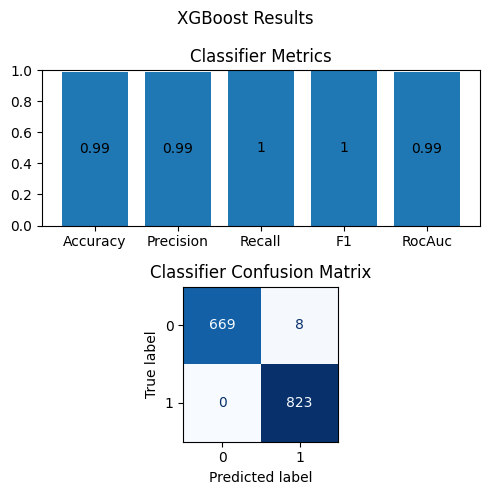

In [23]:
# predict and plot XGBoost results
ypred_xgb = ad.evaluate(xtest_bert, model='xgb')
plot_classification_metrics(ytest, ypred_xgb, plot_title='XGBoost Results')

In [24]:
ad_results = pd.DataFrame(ad.log, index=[0])
ad_results

,train,evaluate_total,evaluate_sample
0,14.67913,0.015651,0.00001


### Concrete

In [25]:
results = {'n_bits': [], 'y_pred': [], 'times': [], 'metrics': []}

for n_bits in range(2,7):

  cad = ConcreteAnomalyDetector(n_bits=n_bits, random_state=1)
  y_pred = cad.train(xtrain_bert).evaluate(xtest_bert, fhe='simulate')
  metrics = {
      'accuracy':   accuracy_score(ytest, y_pred),
      'precision':  precision_score(ytest, y_pred),
      'recall':     recall_score(ytest, y_pred),
      'f1':         f1_score(ytest, y_pred)
  }

  results['n_bits'].append(n_bits)
  results['y_pred'].append(y_pred)
  results['times'].append(cad.log)
  results['metrics'].append(metrics)

100%|██████████| 1500/1500 [00:41<00:00, 36.48it/s]


########################### bits = 2 ###########################


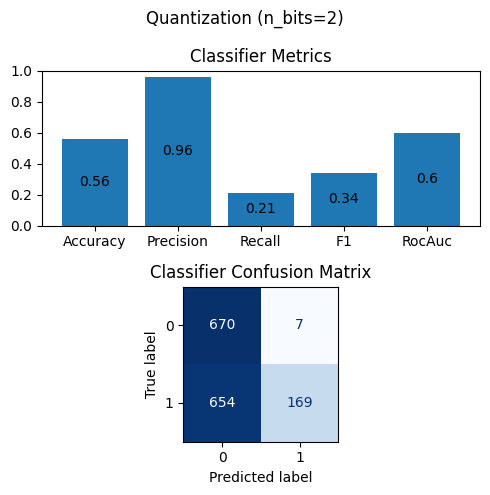

########################### bits = 3 ###########################


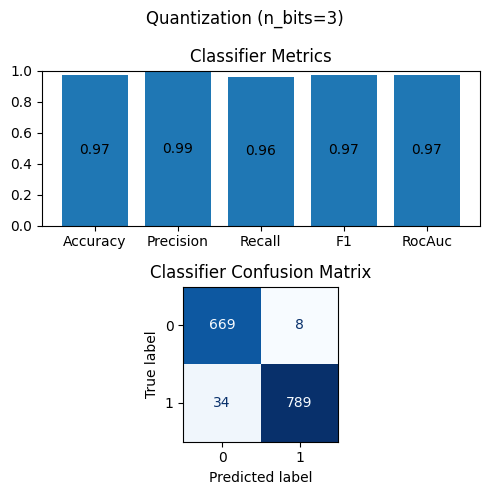

########################### bits = 4 ###########################


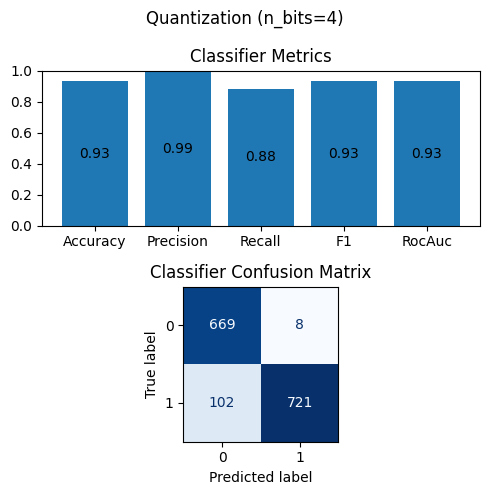

########################### bits = 5 ###########################


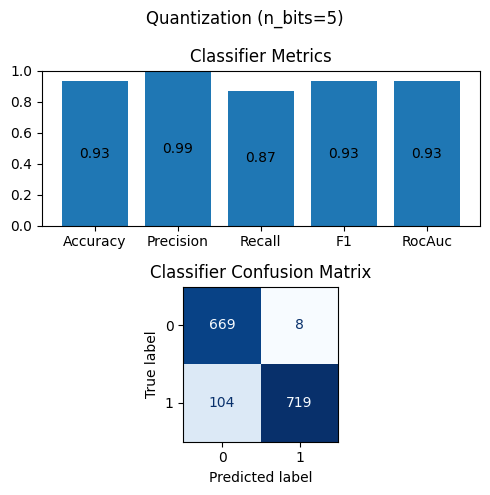

########################### bits = 6 ###########################


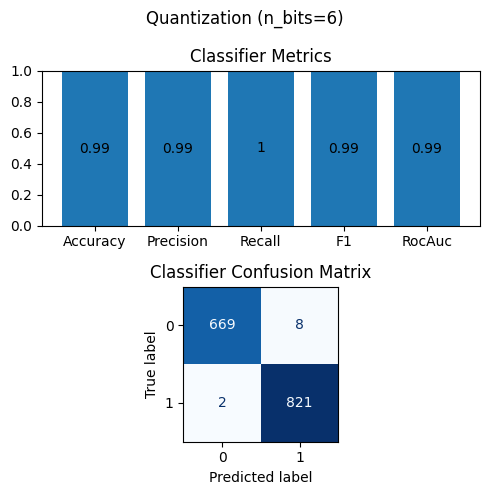

In [26]:
for preds, bits in zip(results['y_pred'], results['n_bits']):
  print(f'########################### bits = {bits} ###########################')
  plot_classification_metrics(ytest, preds, plot_title=f'Quantization (n_bits={bits})')

In [27]:
cad_results = pd.concat([pd.DataFrame.from_records(results['times']), pd.DataFrame.from_records(results['metrics'])], axis=1)
cad_results.insert(0, 'n_bits', results['n_bits'])
cad_results

,n_bits,train,compile,keygen,evaluate_total,evaluate_sample,accuracy,precision,recall,f1
0,2,10.375144,0.913724,4.550597,36.742636,0.024495,0.559333,0.960227,0.205346,0.338338
1,3,11.521386,1.153117,6.905246,40.237015,0.026825,0.972000,0.989962,0.958688,0.974074
2,4,8.444503,0.575002,17.346367,37.212263,0.024808,0.926667,0.989026,0.876063,0.929124
3,5,10.181211,0.565244,46.364462,42.156007,0.028104,0.925333,0.988996,0.873633,0.927742
4,6,9.790773,0.537076,199.095071,41.121490,0.027414,0.993333,0.990350,0.997570,0.993947


## Approach 2: Autoencoder

The idea behind an _Autoencoder_ is to constrain a neural network with a bottleneck, compelling it to compress input data into a reduced representation and then reconstruct the original input. The core objective is to reproduce the input accurately. By comparing the starting input with what the autoencoder rebuilds, we can pinpoint anomalies by noticing where errors in the recreation process are substantially higher.
<br></br>

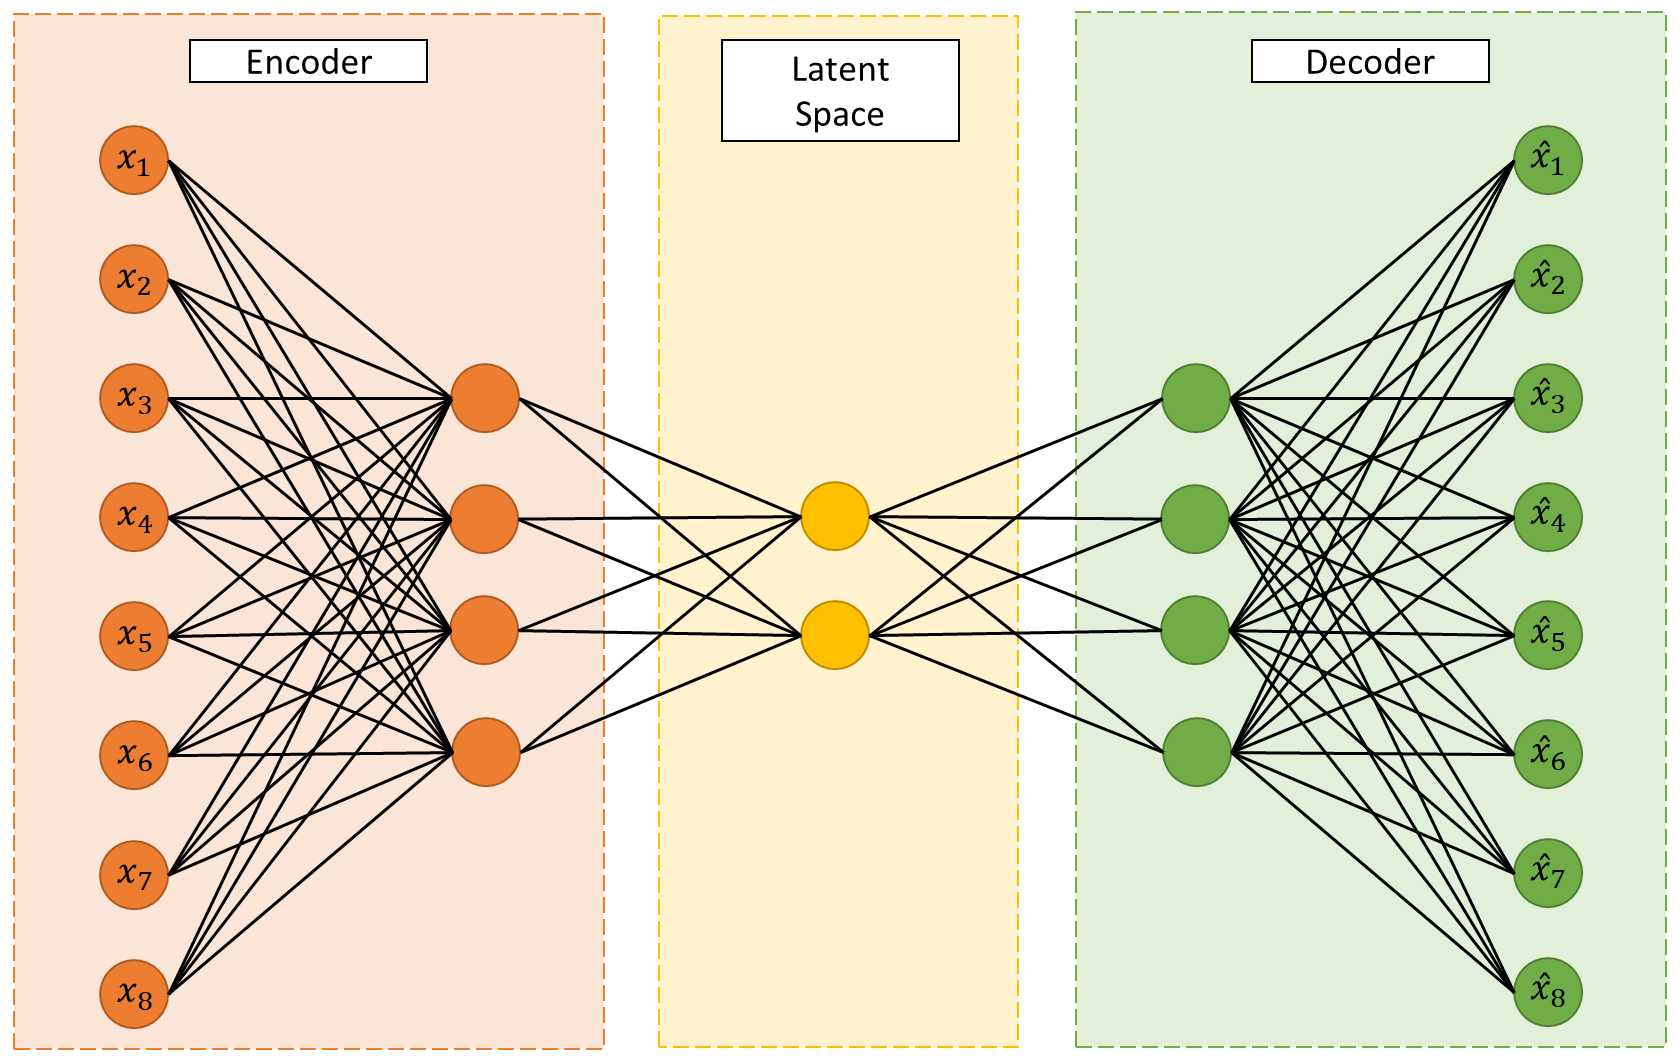

### Functions

In [28]:
################################################################################
# PyTorch Autoencoder
################################################################################

class TorchAutoencoder(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.threshold = None
        self.log = {
            'train': None,
            'evaluate_total': None,
            'evaluate_sample': None
        }

    def train(self, X, epochs=20, verbose=True):
        X_tensor = torch.tensor(np.array(X), dtype=torch.float32)
        self.model = self.model.train()
        # train model
        start_time = time.time()
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            ypred = self.model(X_tensor)
            loss = self.criterion(ypred, X_tensor)
            loss.backward()
            self.optimizer.step()
            print(f'Epoch: {epoch+1}\tLoss: {loss.item():.4f}') if verbose is True else None
        self.log['train'] = time.time() - start_time
        # calculate threshold
        self.model = self.model.eval()
        with torch.no_grad():
            reconstructed_data = self.model(X_tensor)
        reconstruction_error = torch.mean((X_tensor - reconstructed_data)**2, axis=1)
        self.threshold = np.percentile(reconstruction_error, 90)
        return self

    def evaluate(self, X):
        X_tensor = torch.tensor(np.array(X), dtype=torch.float32)
        # evaluate model
        start_time = time.time()
        with torch.no_grad():
            reconstructed_data = self.model(X_tensor)
        reconstruction_error = torch.mean((X_tensor - reconstructed_data)**2, axis=1)
        ypred = np.where(reconstruction_error > self.threshold, 1, 0)
        self.log['evaluate_total'] = time.time() - start_time
        self.log['evaluate_sample'] = self.log['evaluate_total']/X_tensor.shape[0]
        return ypred

################################################################################
# Concrete Autoencoder
################################################################################

class ConcreteAutoencoder(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.threshold = None
        self.fhe_module = None
        self.log = {
            'train': None,
            'compile': None,
            'keygen': None,
            'evaluate_total': None,
            'evaluate_sample': None
        }

    def train(self, X, n_bits, epochs=20, verbose=True):
        X_tensor = torch.tensor(np.array(X), dtype=torch.float32)
        self.model = self.model.train()
        # train model
        start_time = time.time()
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            ypred = self.model(X_tensor)
            loss = self.criterion(ypred, X_tensor)
            loss.backward()
            self.optimizer.step()
            print(f'Epoch: {epoch+1}\tLoss: {loss.item():.4f}') if verbose is True else None
        self.log['train'] = time.time() - start_time
        # calculate threshold
        self.model = self.model.eval()
        with torch.no_grad():
            reconstructed_data = self.model(X_tensor)
        reconstruction_error = torch.mean((X_tensor - reconstructed_data)**2, axis=1)
        self.threshold = np.percentile(reconstruction_error, 90)
        # compile
        start_time = time.time()
        self.fhe_module = compile_brevitas_qat_model(self.model, X_tensor[:100], rounding_threshold_bits=n_bits)
        self.log['compile'] = time.time() - start_time
    	  # check-up
        bitwidth = self.fhe_module.fhe_circuit.graph.maximum_integer_bit_width()
        print('max. bithwidth (16) exceeded!') if bitwidth > 16 else None
        return self

    def evaluate(self, X, fhe='simulate'):
        X_np = np.array(X)
        # key generation
        start_time = time.time()
        self.fhe_module.fhe_circuit.keygen(force=True)
        self.log['keygen'] = time.time() - start_time
        # evaluate model
        start_time = time.time()
        ypred = [
            1 if np.mean((self.fhe_module.forward(X_np[[i], :], fhe=fhe) - X_np[[i], :])**2, axis=1) > self.threshold
            else 0
            for i in tqdm(range(X_np.shape[0]))
            ]
        self.log['evaluate_total'] = time.time() - start_time
        self.log['evaluate_sample'] = self.log['evaluate_total']/X_np.shape[0]
        return ypred

### Pytorch

In [29]:
input_dim = xtrain_bert.shape[1]
# encoding_dim = input_dim // 10
encoding_dim = 50

In [30]:
torch_model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, encoding_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(encoding_dim, input_dim),
    torch.nn.Sigmoid()
)

Epoch: 1	Loss: 0.5769
Epoch: 2	Loss: 0.5663
Epoch: 3	Loss: 0.5571
Epoch: 4	Loss: 0.5465
Epoch: 5	Loss: 0.5345
Epoch: 6	Loss: 0.5214
Epoch: 7	Loss: 0.5073
Epoch: 8	Loss: 0.4925
Epoch: 9	Loss: 0.4771
Epoch: 10	Loss: 0.4613
Epoch: 11	Loss: 0.4453
Epoch: 12	Loss: 0.4292
Epoch: 13	Loss: 0.4132
Epoch: 14	Loss: 0.3974
Epoch: 15	Loss: 0.3820
Epoch: 16	Loss: 0.3671
Epoch: 17	Loss: 0.3527
Epoch: 18	Loss: 0.3390
Epoch: 19	Loss: 0.3259
Epoch: 20	Loss: 0.3134


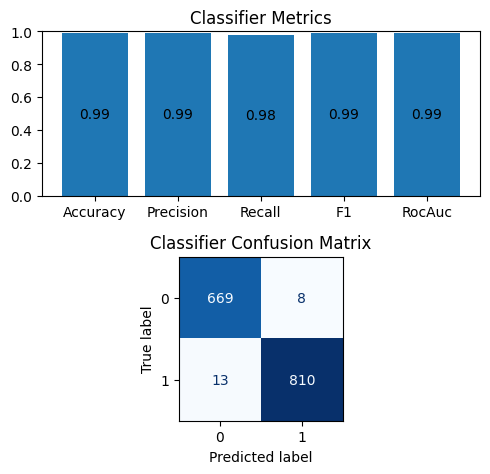

In [31]:
tae = TorchAutoencoder(model=torch_model).train(xtrain_bert)
ypred_tae = tae.evaluate(xtest_bert)
plot_classification_metrics(ytest, ypred_tae)

In [32]:
tae_results = pd.DataFrame(tae.log, index=[0])
tae_results

,train,evaluate_total,evaluate_sample
0,1.648479,0.008625,0.000006


### Concrete

In [33]:
input_dim = xtrain_bert.shape[1]
# encoding_dim = input_dim // 10
encoding_dim = 50

In [ ]:
results = {'n_bits': [], 'y_pred': [], 'times': [], 'metrics': []}

for n_bits in range(2,7):

  brevitas_model = torch.nn.Sequential(
    brevitas.nn.QuantIdentity(bit_width=n_bits, return_quant_tensor=True),
    brevitas.nn.QuantLinear(input_dim, encoding_dim, bias=True, weight_bit_width=n_bits),
    brevitas.nn.QuantReLU(),
    brevitas.nn.QuantLinear(encoding_dim, input_dim, bias=True, weight_bit_width=n_bits),
    brevitas.nn.QuantSigmoid()
  )

  cae = ConcreteAutoencoder(brevitas_model)
  y_pred = cae.train(xtrain_bert, n_bits=n_bits, verbose=False).evaluate(xtest_bert, fhe='simulate')
  metrics = {
      'accuracy':   accuracy_score(ytest, y_pred),
      'precision':  precision_score(ytest, y_pred),
      'recall':     recall_score(ytest, y_pred),
      'f1':         f1_score(ytest, y_pred)
  }

  results['n_bits'].append(n_bits)
  results['y_pred'].append(y_pred)
  results['times'].append(cae.log)
  results['metrics'].append(metrics)

100%|██████████| 1500/1500 [00:08<00:00, 182.55it/s]


In [ ]:
for preds, bits in zip(results['y_pred'], results['n_bits']):
  print(f'########################### bits = {bits} ###########################')
  plot_classification_metrics(ytest, preds, plot_title=f'Quantization (n_bits={bits})')

In [ ]:
cae_results = pd.concat([pd.DataFrame.from_records(results['times']), pd.DataFrame.from_records(results['metrics'])], axis=1)
cae_results.insert(0, 'n_bits', results['n_bits'])
cae_results

In [ ]:
xtrain_bert.shape